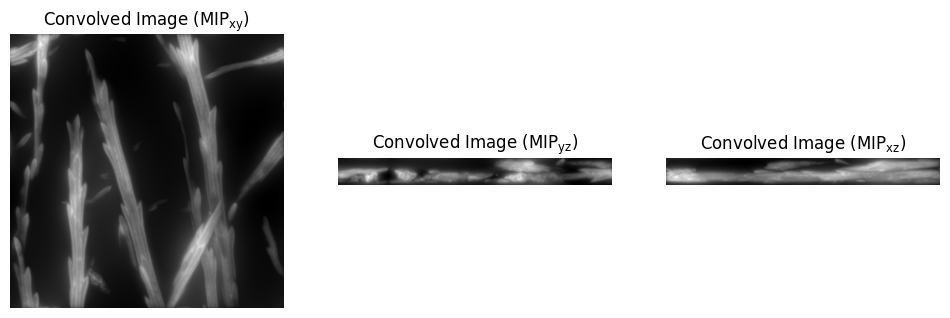

In [ ]:
import sys
sys.path.append('../misc/')

import tifffile as tiff
import numpy as np
from matplotlib import pyplot as plt
import os
from scipy.io import savemat, loadmat

import torch
import torch.nn.functional as F
import torch.nn as nn

from psf_torch import PsfGenerator3D
from utils import *

import random

# 固定随机种子
seed = 100  # 可自行更换为任意整数
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def convolve_3d(data, psf):
    data = fftshift(fftn(ifftshift(data)))
    psf = fftshift(fftn(ifftshift(psf)))

    _im = data * psf
    
    return torch.real(fftshift(ifftn(ifftshift(_im))))

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.cuda.FloatTensor

file_directory = "../source/ours/" # TODO: 替换为你的文件路径
file_name = "LSFM3.tif" # TODO: 替换为你的文件路径
data = tiff.imread(os.path.join(file_directory, file_name)).astype(np.float32)
data = data / data.max() # 归一化
data_shape = data.shape




voxel_unit = (0.5, 0.1, 0.1) # TODO: 替换为你的体素尺寸
wave_length = 0.515 # TODO: 替换为你的波长
n = 1.33 # TODO: 替换为你的折射率
NA = 1.1 # TODO: 替换为你的数值孔径
wavefront = np.zeros(12) # TODO: 像差项，可以设置为12个0或其他值
psf_shape = data_shape

psf_generator = PsfGenerator3D(
    psf_shape=psf_shape,
    units=voxel_unit,
    lam_detection=wave_length,
    n=n,
    na_detection=NA,
)

psf = psf_generator.incoherent_psf(
    nn.parameter.Parameter(torch.from_numpy(wavefront).float()), # 像差项
    normalized=True,
) # 将 Zernike 多项式的系数设置为0

psf = psf / psf.sum()
psf_shape = psf.shape

data = torch.from_numpy(data).float().to(DEVICE)
psf = psf.float().to(DEVICE)

measurement_conv = convolve_3d(data, psf)

measurement_conv = measurement_conv / measurement_conv.max() # 归一化

measurement_conv_np = measurement_conv.detach().cpu().numpy()
plt.figure(figsize = (12, 8))
# 显示卷积结果的最大值投影
plt.subplot(1,3,1); plt.imshow(measurement_conv_np.max(0), cmap = 'gray'); plt.title('Convolved Image (MIP$_{xy}$)'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(measurement_conv_np.max(1), cmap = 'gray'); plt.title('Convolved Image (MIP$_{yz}$)'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(measurement_conv_np.max(2), cmap = 'gray'); plt.title('Convolved Image (MIP$_{xz}$)'); plt.axis('off')
plt.show()

measurement_save = measurement_conv_np * 65535
tiff.imwrite(os.path.join(file_directory, "measurement-"+file_name), measurement_save.astype(np.uint16))
savemat(os.path.join(file_directory, "parameters-"+file_name.split(".")[0]+".mat"), {
    "psf_shape": psf_shape,
    "voxel_unit": voxel_unit,
    "wave_length": wave_length,
    "n": n,
    "NA": NA,
    "wf": wavefront,
})